# Classification. Linear models and KNN

In [312]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [313]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [314]:
from sklearn.exceptions import NotFittedError

In [315]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        z = X.dot(weights)
        return 1 / (1 + np.exp(-z))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        if self.C != 0:
            loss = np.mean(np.log(1 + np.exp(-y * x.dot(weights)))) + np.sum(weights**2) / (2 * self.C)
        else: 
            loss = np.mean(np.log(1 + np.exp(-y * x.dot(weights))))
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        iteration = [0]
        loss_history = []
        loss_history.append(self.get_loss(X_ext, self.weights_, y))
        for i in range(self.max_iter):
            z = y * X_ext.dot(self.weights_)
            sigm = 1 - 1 / (1 + np.exp(-z))
            if self.C != 0:
                delta = X_ext.T.dot(y * sigm) / len(X_ext) - self.weights_ / self.C
            else:
                delta = X_ext.T.dot(y * sigm) / len(X_ext)
            self.weights_ += self.eta * delta
            loss_history.append(self.get_loss(X_ext, self.weights_, y))
            iteration.append(i + 1)
            if np.linalg.norm(delta) < self.tol:
                break
        return loss_history, iteration
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_proba = self.predict_proba(X)
        y_proba[y_proba >= 0.5] = 1
        y_proba[y_proba < 0.5] = -1
        return y_proba

In [316]:
from sklearn import datasets
from sklearn import metrics

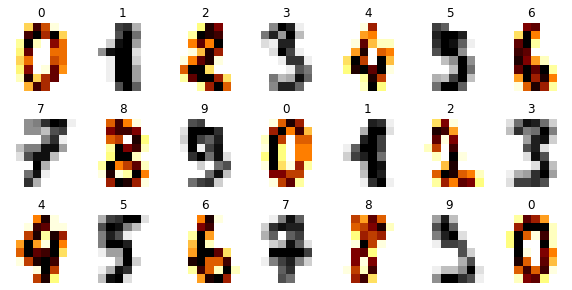

In [317]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [318]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [319]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    loss, iteration = clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), \
           loss, \
           iteration

In [320]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [321]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [322]:
lr_clf.fit(X_train, y_train)

([0.6931471805599453, 0.6736063862205759], [0, 1])

In [323]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [324]:
model = CustomLogisticRegression()

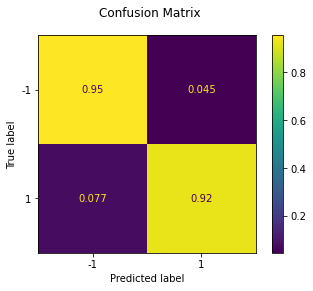

In [325]:
train_acc, test_acc, loss, iteration = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [326]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [327]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Iteration, on which extremum was reached:  1000


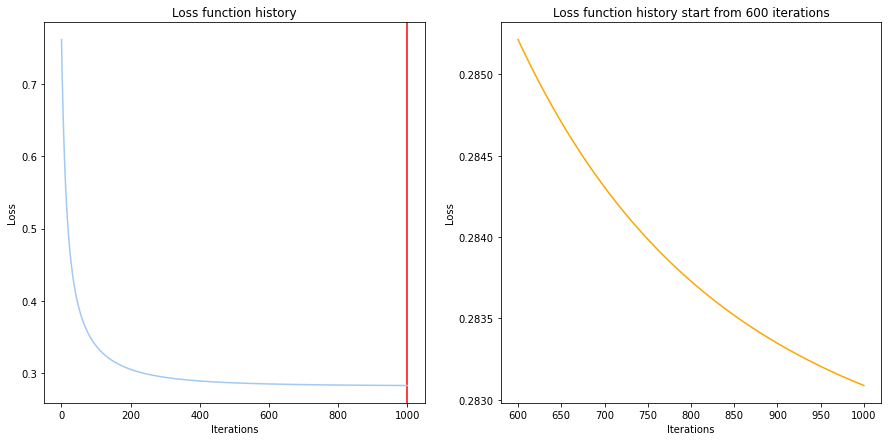

In [328]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].axvline(np.argmin(loss), color='red')
sns.lineplot(x=iteration, y=loss, ax=ax[0])
ax[0].set_title('Loss function history')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')

sns.lineplot(x=iteration[600:], y=loss[600:], ax=ax[1], color='orange')
ax[1].set_title('Loss function history start from 600 iterations')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Loss')

print('Iteration, on which extremum was reached: ', np.argmin(loss))

The left graph shows that the loss function decreases as the number of iterations increases. The criterion for stopping the gradient descent turned out to be the number of iterations. On the right graph, I duplicated the graph of the loss function, but for iterations greater than 600, to see that the loss function decreases. This tells us that the learning rate is well chosen and we haven't made a divergence.  

The red line indicates the minimum of the loss function, which is reached at 1000 iterations. 

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Let's look at the loss function and the accuracy of the model as a function of learning rates.

In [329]:
def model_evaluation(model, param):
    loss, iteration = model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print('Parametr =', param)
    print('Test acuuracy:', test_acc)
    print('Train acuuracy:', train_acc)
    print('-' * 20)
    sns.lineplot(x=iteration, y=loss, label=param)
    plt.legend()

Parametr = 0.001
Test acuuracy: 0.9055555555555556
Train acuuracy: 0.894919972164231
--------------------
Parametr = 0.005
Test acuuracy: 0.9388888888888889
Train acuuracy: 0.9109255393180237
--------------------
Parametr = 0.025
Test acuuracy: 0.5305555555555556
Train acuuracy: 0.5483646485734168
--------------------


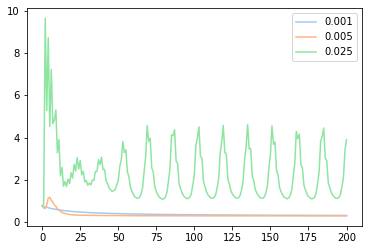

In [330]:
RATES = [0.001, 0.005, 0.025]
for rate in RATES:
    model = CustomLogisticRegression(eta=rate, max_iter=200)
    model_evaluation(model, rate)

In the first case we took small learning rates, the best result we got for Rate = 0.005. Further, as the parameter increases, the accuracy of the model decreases. The convergence of the gradient descent becomes worse. For clarity, let's see what happens, there is to take a fairly large learning rate (I proceeded from the logic that usually the learning rate is taken in the range from 0 to 1).

Parametr = 0.05
Test acuuracy: 0.5611111111111111
Train acuuracy: 0.5838552540013918
--------------------
Parametr = 0.1
Test acuuracy: 0.5277777777777778
Train acuuracy: 0.5455810716771051
--------------------
Parametr = 0.5
Test acuuracy: 0.49166666666666664
Train acuuracy: 0.4968684759916493
--------------------


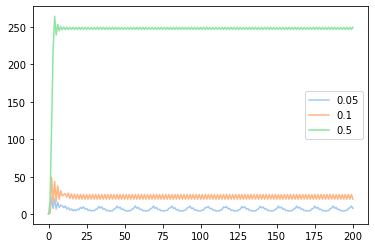

In [331]:
RATES = [0.05, 0.1 , 0.5]
for rate in RATES:
    model = CustomLogisticRegression(eta=rate, max_iter=200)
    model_evaluation(model, rate)

From the graphs we can conclude that indeed, the learning rate directly affects the convergence of the model. If the learning rate for the gradient descent is large enough, then you can simply miss the extremum, then the gradient descent will not converge at all even if you increase the number of iterations.  

Also, taking too small weights is not appropriate either (the accuracy for 0.005 was higher than 0.001), as a larger number of iterations may be needed, which will increase the learning time. Therefore, it is important to determine the optimal learning rate.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Let's firstly look at the weights of the model and count their $||w||_2$.

In [332]:
print('First 10 weights', model.weights_[:10])
print('Weights norm', np.linalg.norm(model.weights_))

First 10 weights [-1.63535143e-01  4.31508002e-63 -9.97448388e-03 -3.23590814e-01
 -1.74901415e+00 -1.49431686e+00  3.84133612e-01  3.68128045e-01
  3.22430990e-02 -1.62375319e-03]
Weights norm 9.722070367494107


By virtue of the fact that weight regularization has been applied, the weights and their norm look good. The model is not overfitted. Especially when you consider the fact that for both the training and test datasets the score was good. It is interesting to see what happens to the model if regularization is removed.

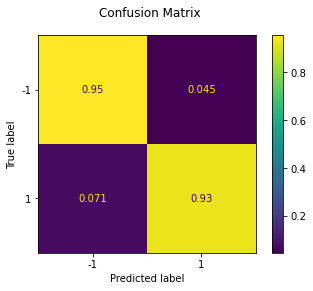

First 10 weights [-0.00186151  0.00693407  0.00229947  0.03526204  0.07269511  0.01023371
  0.14064081  0.09899053  0.00440876  0.00245639]
Weights norm 0.4182140390811487
Train score 0.9144050104384134
Test score 0.9416666666666667


In [333]:
model = CustomLogisticRegression(C=0)
train_acc, test_acc, loss, iteration = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('First 10 weights', model.weights_[:10])
print('Weights norm', np.linalg.norm(model.weights_))
print('Train score', train_acc)
print('Test score', test_acc)

We got even better results than with regularization! This can be explained by the fact that there is no multicolinearity in the dataset, which leads to overfitting. Now let's see how the loss function behaves when we change the regularization parameter.

Parametr = 0
Test acuuracy: 0.9416666666666667
Train acuuracy: 0.9144050104384134
--------------------
Parametr = 0.001
Test acuuracy: 0.8694444444444445
Train acuuracy: 0.8385525400139179
--------------------
Parametr = 0.005
Test acuuracy: 0.8722222222222222
Train acuuracy: 0.8420320111343076
--------------------
Parametr = 0.01
Test acuuracy: 0.875
Train acuuracy: 0.8455114822546973
--------------------
Parametr = 0.05
Test acuuracy: 0.8972222222222223
Train acuuracy: 0.871955462769659
--------------------
Parametr = 0.5
Test acuuracy: 0.9277777777777778
Train acuuracy: 0.9039665970772442
--------------------


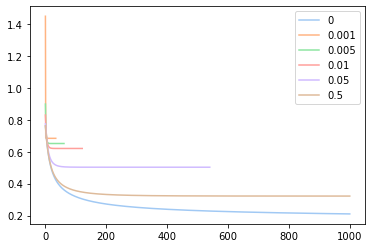

In [334]:
C = [0, 0.001, 0.005, 0.01, 0.05, 0.5]
for c in C:
    model = CustomLogisticRegression(C=c)
    model_evaluation(model, c)

We got a pretty interesting result. As shown earlier, at 0 we get a good model. In fact, for the current data we could do without regularization. It is also worth noting that for small values of parameters the gradient descent converges quickly, but the model at these parameters shows worse results than models with larger values of resularization parameters.

**(0.5 points)** Compare zero initialization and random initialization. 

Random initiation


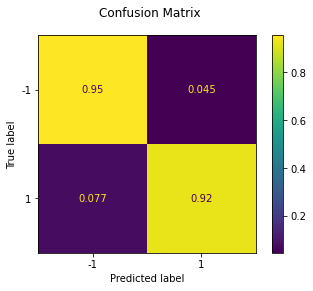

Train accurancy 0.9109255393180237
Test accurancy 0.9388888888888889
Zero initiation


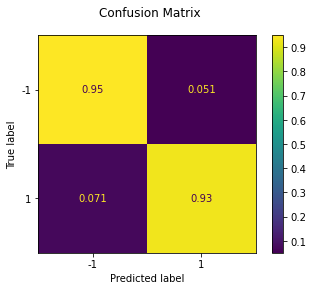

Train accurancy 0.9116214335421016
Test accurancy 0.9388888888888889


Text(0.5, 1.0, 'Loss function — Weights initiation')

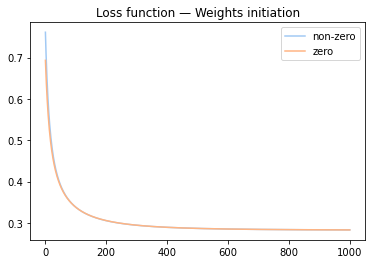

In [335]:
model = CustomLogisticRegression(zero_init=False)
print('Random initiation')
train_acc, test_acc, loss, iteration = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Train accurancy', train_acc)
print('Test accurancy', test_acc)

print('Zero initiation')
model = CustomLogisticRegression(zero_init=True)
train_acc, test_acc, loss_0, iteration = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Train accurancy', train_acc)
print('Test accurancy', test_acc)

sns.lineplot(x=iteration, y=loss, label='non-zero')
sns.lineplot(x=iteration, y=loss_0, label='zero')
plt.legend()
plt.title('Loss function — Weights initiation')

We can see from the confusion matrix and the line graph that the results of the classifier with zero and random initialization of weights are almost identical. However, according to the accuracy of the model, we can see that the zero initialization of weights is slightly better.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [336]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = []
        for x in X:
            P.append([np.linalg.norm(x-y) for y in Y])
        return np.array(P)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        y_weights_df = pd.DataFrame(zip(y, weights), columns=['y', 'weights'])
        return y_weights_df.groupby('y')['weights'].sum().reindex(self.classes_)

    def get_weights(self, pair_tuple):
        weights_of_points = np.zeros(len(self.classes_))
        for t in pair_tuple:
            pair_list = list(t)
            if self.weights == 'distance':
                weight = 1 / (pair_list[0] + self.eps)
                weights_of_points[pair_list[1]] += weight
            else:
                weights_of_points[pair_list[1]] += 1
        return np.array(weights_of_points)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            proba = np.empty([len(X), len(self.classes_)], int)
            for i, row in enumerate(P):
                k_nearest = sorted(zip(row, self.y), key=lambda x: x[0])[:self.n_neighbors]
                weights = self.get_weights(k_nearest)
                class_proba = weights / np.sum(weights)
                proba = np.append(proba, np.array([class_proba]), axis=0)  
            return proba[len(X):]         
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        class_proba = []
        proba = self.predict_proba(X)
        for i in proba:
            class_proba.append(np.argmax(i))
        return class_proba


In [337]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [338]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [339]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

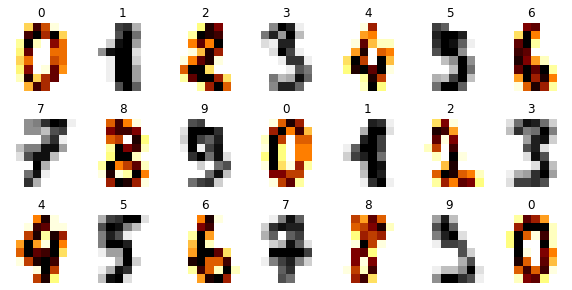

In [340]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [341]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)))

KNeighborsClassifier(weights='distance')

In [342]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [343]:
def fit_evaluate_knn(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
           

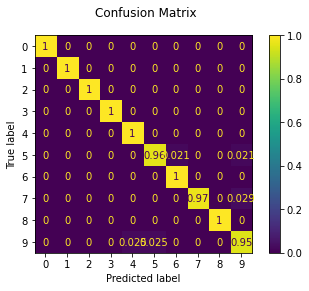

In [344]:
train_acc, test_acc = fit_evaluate_knn(model, X_train, y_train, X_test, y_test)

In [345]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

We can see from the confusion matrix that in general kNN classifies numbers perfectly. However, we can also see that in some cases 
* 5 was predicted to be 6 (0.021) or 9 (0.021)
* 7 was predicted to be 9 (0. 029)
* 9 was predicted as 4 (0.025), 5 (0.025) 

I can justify these results by the fact that the numbers are outwardly similar to each other in handwriting. For example, if you finish drawing a pair of lines in 4, you get 9. 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [346]:
def n_neighbors_accurancy(lower_bound, upper_bound, weights='distance'):
    n_neighbors = np.linspace(lower_bound, upper_bound, 15).astype(int)
    test_acc = []
    for n in n_neighbors:
        model = CustomKNeighborsClassifier(n_neighbors=n, weights=weights)
        model.fit(X_train, y_train)
        test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    return test_acc, n_neighbors

,n_neighbors,accurancy
0,1,0.977778
1,103,0.938889
2,206,0.905556
3,308,0.894444
4,411,0.894444
5,513,0.875000
6,616,0.866667
7,719,0.866667
8,821,0.875000
9,924,0.872222


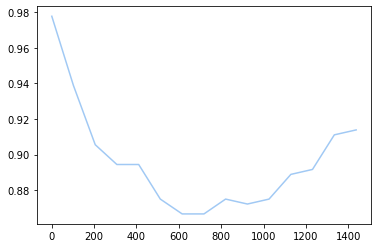

In [347]:
test_acc, n_neighbors = n_neighbors_accurancy(1, len(X_train))
sns.lineplot(x=n_neighbors, y=test_acc)
pd.DataFrame({'n_neighbors': n_neighbors, 'accurancy': test_acc})

In the graph above, we can see that the accuracy of the model decreases as the number of neighbors increases, 600+ after which we can see an increase in accuracy. I will suggest that this increase is of random nature. Let's test this assumption by considering the number of neighbors > 600+. 

<AxesSubplot:>

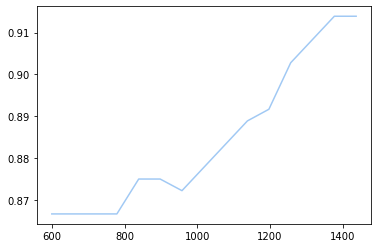

In [348]:
test_acc, n_neighbors = n_neighbors_accurancy(600, len(X_train))
sns.lineplot(x=n_neighbors, y=test_acc)

Although the graph shows that in general there is an increase in accuracy as the number of neighbors increases. But still the presence of small peaks suggests that some values make predictions worse than the preceding values. This is most likely because more different classes are included in the prediction and the number of y different classes may be affected to a greater extent, and the fact of distance itself is affected to a lesser extent.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

<AxesSubplot:>

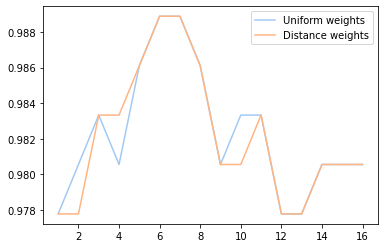

In [349]:
test_acc_uniform, n_neighbors = n_neighbors_accurancy(1, 16, weights='uniform')
test_acc_distance, n_neighbors  = n_neighbors_accurancy(1, 16)

sns.lineplot(x=n_neighbors, y=test_acc_uniform, label='Uniform weights')
sns.lineplot(x=n_neighbors, y=test_acc_distance, label='Distance weights')

In [350]:
pd.DataFrame([test_acc_uniform, test_acc_distance], index=['uniform', 'distance'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
uniform,0.977778,0.980556,0.983333,0.980556,0.986111,0.988889,0.988889,0.986111,0.980556,0.983333,0.983333,0.977778,0.977778,0.980556,0.980556
distance,0.977778,0.977778,0.983333,0.983333,0.986111,0.988889,0.988889,0.986111,0.980556,0.980556,0.983333,0.977778,0.977778,0.980556,0.980556


Both 'uniform' and 'distance' weights show almost identical results. In some cases (based on the number of neighbors), 'uniform' performs better than 'distance' and vice versa. 

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

In [351]:
test_acc = []
distance = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'mahalanobis']
for d in distance:
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric=d)
    knn.fit(X_train, y_train)
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

metrics_score = pd.DataFrame({'distance': distance, 'score': test_acc})

In [352]:
metrics_score

,distance,score
0,euclidean,0.986111
1,manhattan,0.986111
2,chebyshev,0.986111
3,minkowski,0.986111
4,mahalanobis,0.986111


As we can see, for the selected dataset, the metrics showed a very good identical result.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

**Euclidean Distance** is used when we have to calculate the distance of real values like integer, float. But we have to normalize or standard the data. So, as we have real values in the current task, Euclidean Distance is suitable.  

**Manhatten Distance**  is used in case of high dimensional data. Manhattan gives robust results in case when the data has discrete and binary attributes.

**Mahalanobis Distance** is an effective method to calculate the similarity of two unknown sample sets. Different from Euclidean distance, it takes into account the relationship between various characteristics and is scale independent,
that is, independent of the measurement scale.


## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


**NOTE:** For this assignment, I will use excerpts from my research done in EDA task.

[Assignment 2](https://github.com/VictoriaLebedeva/eda-ml-2022/blob/main/tabular_playground_series.ipynb)

In short, prevously I got the following conclusion about survival rate.

> With the help of EDA I was able to find out that the most significant survival factors were Sex (more important) and Pclass. And the high survival 
> rate among 1st and 2nd class passengers is due to the fact that these people were closer to the evacuation zone at the time of the accident.

> More data insights:
> * **Children**. Children (44%) actually had a better chance of survival than adults (40%). However, pclass also mattered for the child as much as for the adult. It has been observed that children who were on board with one parent had a better chance of survival.
> * **Men**. Unfortunately for men, only the pclass mattered: closeness to the evacuation zone.
> * **Port of Emabarkation**. It has been shown that the distribution of survivors by port is related to the distribution of classes of passengers who boarded at a particular port. So, this feature is less important, than passengers class.
> * **Fare**. Cost of the ticket was realated to passengers class.
> * **Number of family members**. Members of families where the number of people was more than 3 were less likely to survive.
Thus, the success of rescue from the Titanic depended on the gender of the passenger, whether the passenger was a child, and his closeness to the evacuation zone at the time of the disaster.

### Data Ingestion

In [353]:
# get data path
PATH = "./data"
df = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

# frame preprocessing
df.columns = df.columns.str.lower()

In [354]:
df.head().append(df.tail())

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [355]:
print('Number of observaions:', df.shape[0])
print('Number of observaions:', df.shape[1])

Number of observaions: 100000
Number of observaions: 11


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

<AxesSubplot:title={'center':'Sex — Survived'}, xlabel='sex', ylabel='count'>

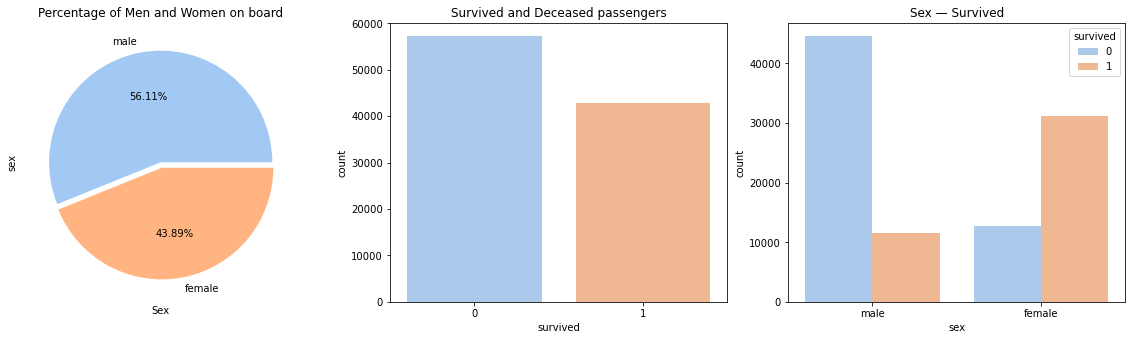

In [356]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.tight_layout(pad=3.0)
sns.set_palette("pastel")

ax[0].set_title('Percentage of Men and Women on board')
ax[0].set_xlabel('Sex')
df['sex'].value_counts().plot.pie(ax=ax[0], autopct = '%1.2f%%', explode=[0, 0.05])

ax[1].set_title('Survived and Deceased passengers')
ax[1].set_xlabel('Survived')
ax[1].set_ylabel('Number of Passengers')
sns.countplot(x='survived', data=df, ax=ax[1])

ax[2].set_title('Sex — Survived')
ax[2].set_xlabel('Sex')
ax[2].set_ylabel('Number of Passengers')
sns.countplot(x='sex', data=df, ax=ax[2], hue='survived')

From the graphs above we can see that
* There were more men on board (~56.11%) than women **(first plot)**.
* There were more deaths as a result of the disaster than survivors **(second plot)**.
* There were more women among the surviving passengers **(third plot)**. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(643.4181818181817, 0.5, 'Number of Passengers')

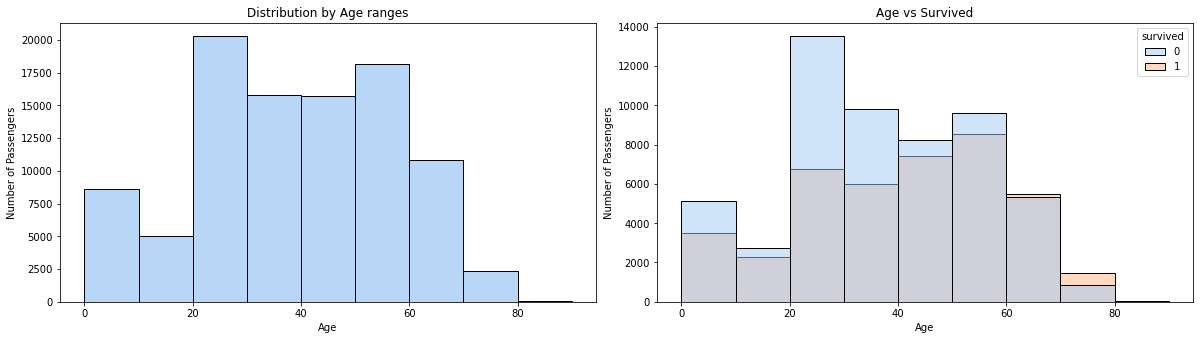

In [357]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
fig.tight_layout(pad=3.0)
sns.set_palette("pastel")

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

sns.histplot(df, x='age', bins=bins, ax=ax[0])
ax[0].set_title('Distribution by Age ranges')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Number of Passengers')

sns.histplot(df, x='age', hue='survived', bins=bins, ax=ax[1])
ax[1].set_title('Age vs Survived')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Number of Passengers')


The distribution of age is slightly right skewed. As we can see, it was mostly people from 20 to 60 years old who were on board the Titanic. There were more children than teenagers. Old people were the least numerous.  

You can see from the graph that, in general, the survival rate among people over 60 is higher than that of people under 20. We can also see that the greatest number of victims was between the ages from 20 to 40.

In [358]:
pd.DataFrame(df.groupby('survived')['age'].describe())

,count,mean,std,min,25%,50%,75%,max
survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


Judging by the descriptive statistics, the passengers who survived were, on average, slightly older than those who died.

In [359]:
print('Ratio of survivors to the total number of passengers by age group')
print('Children (0-16):', round(df[(df['age'] <= 16) & (df['survived'] == 1)].shape[0] / df[df['age'] <= 16].shape[0] * 100, 3))
print('Adult (17-60):', round(df[(df['age'].between(16, 60)) & (df['survived'] == 1)].shape[0] / df[df['age'].between(16, 60)].shape[0] * 100, 3))
print('Elderly people (61-90):', round(df[(df['age'] >= 60) & (df['survived'] == 1)].shape[0] / df[df['age'] >= 60].shape[0] * 100, 3,))

Ratio of survivors to the total number of passengers by age group
Children (0-16): 44.189
Adult (17-60): 40.895
Elderly people (61-90): 52.954


The difference in age between the survivors and the dead is due to the fact that the older passengers traveled first class.

([<matplotlib.axis.XTick at 0x2174b20e550>,
 [Text(0, 0, '1st class'), Text(1, 0, '2nd class'), Text(2, 0, '3rd class')])

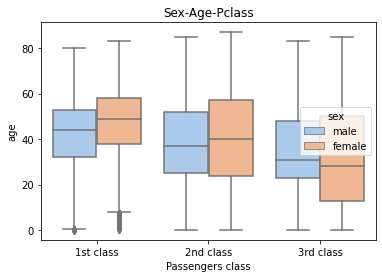

In [360]:
sns.boxplot(x='pclass', y='age', hue='sex', data=df)
plt.xlabel('Passengers class')
plt.title('Sex-Age-Pclass')
plt.xticks(np.arange(3), ['1st class', '2nd class', '3rd class'])

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0.5, 24.0, 'Port of embarkation')

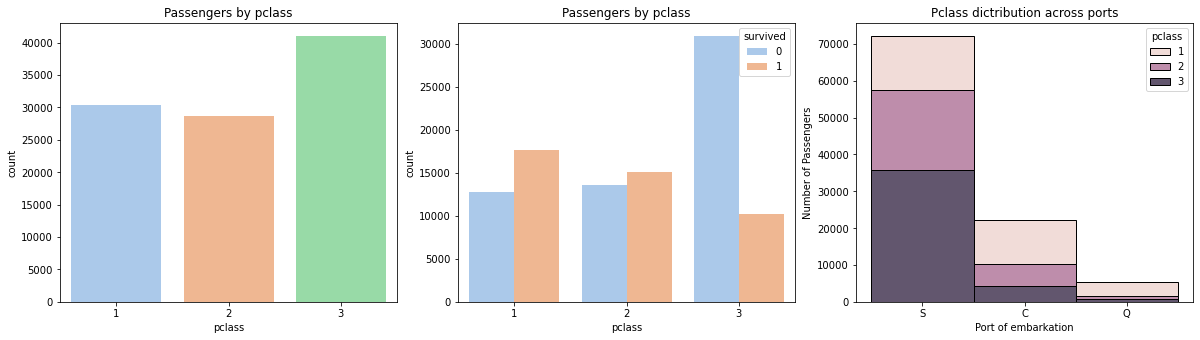

In [361]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.tight_layout(pad=3.0)

ax[0].set_title('Passengers by pclass')
ax[0].set_ylabel('Number of Passengers')
sns.countplot(x='pclass', data=df, ax=ax[0])

ax[1].set_title('Passengers by pclass')
ax[1].set_ylabel('Number of Passengers')
sns.countplot(x='pclass', data=df, hue='survived', ax=ax[1])

sns.histplot(x='embarked', hue='pclass', data=df, multiple='stack', ax=ax[2])
ax[2].set_title('Pclass dictribution across ports')
ax[2].set_ylabel('Number of Passengers')
ax[2].set_xlabel('Port of embarkation')

Most of the passengers traveled in third class, with almost equal numbers of first and second class passengers. First class passengers had a better (slightly better) chance of survival than second and third class passengers. The greatest number of deaths was among third-class passengers. Port of embarkation has no effect on the chances of survival, due to the distribution of passengers of different classes between these ports, as the graph confirms.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [362]:
print('Persentage of missing values:')
df.isnull().sum() / df.shape[0] * 100

Persentage of missing values:


survived     0.000
pclass       0.000
name         0.000
sex          0.000
age          3.292
sibsp        0.000
parch        0.000
ticket       4.623
fare         0.134
cabin       67.866
embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We see the missing values in the columns:
1) **Age**. Here the forgiven values are about 3 percent. You can delete them, as some information will be lost. But it is worth trying to fill in the missing data. This is good practice, because often the quality of the model is poor, because it, in particular, did not have enough data to learn. In the case of age, the data can be filled in with the average value. Machine learning techniques are also used in practice.

2) There are also columns that contain irrelevant data, such as **Ticket** (4.623%). Such attributes can be omitted from the model. 

3) There is a trait with 67.866% missing values. This is **Cabin**. In my research (there is a link at the beginning of the third assignment), it was shown that, in theory, the location of the Cabin played a role in saving the passengers. However, to apply this feature in the classifier, you must fill in the missing values. Because there are too many missing values, we may reconstruct the data incorrectly, which would add noise to our model. Therefore, it is also advisable not to include the feature in the model. 

4) There are not many forgiven values in **Fare** and **Embarked**, so you can just delete those rows. 


In [363]:
df = df.drop('cabin', axis=1)
df.groupby(['sex', 'pclass'])['age'].mean().round()

sex     pclass
female  1         47.0
        2         39.0
        3         32.0
male    1         42.0
        2         38.0
        3         34.0
Name: age, dtype: float64

In [364]:
# replace values by condition
df.loc[(df['sex'] == 'female') & (df['pclass'] == 1) & df['age'].isna(), 'age'] = 47
df.loc[(df['sex'] == 'female') & (df['pclass'] == 2) & df['age'].isna(), 'age'] = 39
df.loc[(df['sex'] == 'female') & (df['pclass'] == 3) & df['age'].isna(), 'age'] = 32

df.loc[(df['sex'] == 'male') & (df['pclass'] == 1) & df['age'].isna(), 'age'] = 42
df.loc[(df['sex'] == 'male') & (df['pclass'] == 2) & df['age'].isna(), 'age'] = 38
df.loc[(df['sex'] == 'male') & (df['pclass'] == 3) & df['age'].isna(), 'age'] = 34

In [365]:
df = df.dropna(axis=0)
df.isna().sum()

survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### Features preparation

Let's start by separating the whole variable from the predictors. 

In [366]:
y = df['survived']
X = df.drop('survived', axis=1)

Let's look at the data types again.

In [367]:
X.dtypes

pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
embarked     object
dtype: object

The passenger name can be considered irrelevant, as well as the Ticket feature. So let's exclude these attributes from the dataset.  

And encode the remaining categorical variables.


In [368]:
# drop irrelevant features
X = X.drop(['name', 'ticket'], axis=1)

# encode categorical features
sex = pd.get_dummies(X['sex'], drop_first=True, prefix='sex')
embark = pd.get_dummies(X['embarked'], drop_first=True, prefix='embarked')
X = pd.concat([X, sex, embark], axis=1)

# drop categorical features
X.drop(['sex','embarked'], axis=1,inplace=True)


Split dataset on training and test.

In [369]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

#### Logistic regression

In [370]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()
clf.fit(X_train,y_train)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores (Train) :', scores)
print('Accuracy score (Test) :', clf.score(X_val, y_val))
print('Model coefs: ', clf.coef_)

Cross-Validation Accuracy Scores (Train) : [0.77121431 0.76983292 0.76942306 0.77297546 0.77764621]
Accuracy score (Test) : 0.7669718976949794
Model coefs:  [[-5.39263915e-01 -1.82024693e-04 -8.80617249e-02 -3.77303962e-02
   1.33010974e-03 -2.00935275e+00 -8.10123823e-01 -1.17614432e+00]]


<AxesSubplot:>

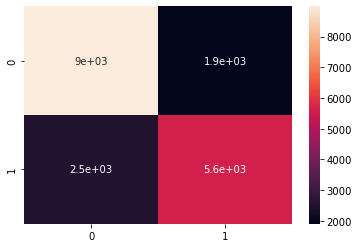

In [372]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, clf.predict(X_val))
sns.heatmap(confusion_matrix, annot=True)

#### kNN 

In [374]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)

scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores (Train) :', scores)
print('Accuracy score (Test) :', knn_clf.score(X_val, y_val))

Cross-Validation Accuracy Scores (Train) : [0.72523352 0.723589   0.73080718 0.72297875 0.73363595]
Accuracy score (Test) : 0.7300284180612567


For starters, the results are bearable: Logistic regression showed better results than kNN. However, now let's try to improve the model predictions. 

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

SibSp and Parch can be combined into one column, since they carry information about family members. 

#### Feature engineering

In [375]:
from sklearn.preprocessing import StandardScaler

X['family_size'] = X['sibsp'] + X['parch'] + 1

pclass = pd.get_dummies(X['pclass'], drop_first=True, prefix='pclass_')
X = pd.concat([X, pclass], axis=1)
X.drop('pclass', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [376]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

#### Logistic regression tuning

In [377]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores (Train) :', scores)
print('Accuracy score (Test) :', clf.score(X_val, y_val))

Cross-Validation Accuracy Scores (Train) : [0.77141166 0.77134588 0.77738307 0.77356753 0.77975133]
Accuracy score (Test) : 0.7679191664035365


In [378]:
clf = LogisticRegression()

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C':  [100, 10, 1.0, 0.1, 0.01]
}

grid_search = GridSearchCV(clf, param_grid=param_grid,
                           n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.774823 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


#### kNN tuning

In [379]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": np.arange(2, 10),
    "weights": ["uniform", "distance"]
}

gscv = GridSearchCV(knn_clf, cv=5, param_grid=param_grid, scoring='accuracy')
gscv_result = gscv.fit(X_train, y_train)


In [380]:
best_acc_score=gscv_result.best_score_
best_params=gscv_result.best_params_

In [381]:
best_acc_score, best_params

(0.7621798419098391, {'n_neighbors': 9, 'weights': 'uniform'})

Actually, we've got a better result than previous kNN model. Probably, scaling data had an affect on prediction ability. But it is still not enough for good prediction. 

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

So, for predicting test data, I will use Logistic Regression

In [382]:
def data_preprocessing(X):
    # columns to lowercase
    X.columns = X.columns.str.lower()

    X = X.drop(['cabin', 'passengerid'], axis=1)

    # fill age column 
    X.loc[(X['sex'] == 'female') & (X['pclass'] == 1) & X['age'].isna(), 'age'] = 47
    X.loc[(df['sex'] == 'female') & (X['pclass'] == 2) & X['age'].isna(), 'age'] = 39
    X.loc[(df['sex'] == 'female') & (X['pclass'] == 3) & X['age'].isna(), 'age'] = 32

    X.loc[(X['sex'] == 'male') & (X['pclass'] == 1) & X['age'].isna(), 'age'] = 42
    X.loc[(X['sex'] == 'male') & (X['pclass'] == 2) & X['age'].isna(), 'age'] = 38
    X.loc[(X['sex'] == 'male') & (X['pclass'] == 3) & X['age'].isna(), 'age'] = 34

    # encode categorical features
    sex = pd.get_dummies(X['sex'], drop_first=True, prefix='sex')
    embark = pd.get_dummies(X['embarked'], drop_first=True, prefix='embarked')
    X = pd.concat([X, sex, embark], axis=1)

    # drop categorical features
    X.drop(['sex','embarked', 'name', 'ticket'], axis=1,inplace=True)

    X['family_size'] = X['sibsp'] + X['parch'] + 1

    pclass = pd.get_dummies(X['pclass'], drop_first=True, prefix='pclass_')
    X = pd.concat([X, pclass], axis=1)
    X.drop('pclass', axis=1)

    X['age'] = X['age'].fillna(X['age'].mean())
    X['fare'] = X['fare'].fillna(X['fare'].mean())

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X

In [383]:
test = pd.read_csv('data\\titanic\\test.csv')

x_test = data_preprocessing(test)
y_predict = grid_result.predict(x_test)

In [384]:
submit = pd.DataFrame({'PassengerId': test['passengerid'], 'Survived': y_predict})
submit.to_csv('submit.csv', index = False)
submit.head()

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1


<img src="score_kaggle_2.png"/>

If GitHub hasn't render the picture of the Kaggle Score, it can be found by the link
[Kaggle competition score](https://github.com/VictoriaLebedeva/classification/blob/main/score_kaggle_2.png)